# Tests of the input parameters for the fragment calculations of the water dimer

In another tutorial, it was shown how to run BigDFT fragment calculations and how the values of *nbasis* (the number of support function per atom) affects the dissociation curve of the water dimer: increasing this *nbasis* for both oxygen and hydrogen atoms proved to increase the agreement with the usual cubic BigDFT calculation.

The aim of the present tutorial is to present the influence of other input parameters, such as the localization radii *r_loc* and the grid extension parameters *crmult* and *frmult*.

**Import modules, classes and functions.**

In [1]:
from __future__ import print_function
import os
import sys
import subprocess
import shutil
import tarfile
import numpy as np
from futile.Utils import find_files
from BigDFT import Logfiles as lf
import matplotlib.pyplot as plt

**Extract tarfiles to avoid re-running some calculations.**

One tarfile contains the templates used throughout this notebook, while the other contains the files related to the different dissociation curves that will be computed.

In [2]:
# Extract the archive containing the templates, if it exists
tartemplate = "templates_tests_H2O.tgz"
if os.path.exists(tartemplate):
    print("Extract {} to avoid calculating the templates.".format(tartemplate))
    with tarfile.open(tartemplate,"r:bz2") as tar:
        tar.extractall()
        
# Extract the output files from an archive, if it exists
tarname = 'H2O_dimer_tests.tgz'
if os.path.exists(tarname):
    print("Extract {} to avoid calculating every point of the dissociation curves.".format(tarname))
    with tarfile.open(tarname,"r:bz2") as tar:
        tar.extractall()

**Initialize some variables to get a clean tree of folders.**

In [3]:
# Path leading to the current folder
start_path = os.getcwd() 

# Templates folder
templates_folder = "templates" # Name
templates_path = start_path+"/"+templates_folder # Path leading to it
if not os.path.exists(templates_folder): os.mkdir(templates_folder)

# Dimer folder
dimer_folder = "H2O_dimer" # Name
dimer_path = start_path+"/"+dimer_folder # Path leading to it
if not os.path.exists(dimer_folder): os.mkdir(dimer_folder)

**Define the BigDFT variable allowing to run BigDFT from the present notebook**

In [4]:
# Define the variables to run a calculation
BigDFT = os.environ["BIGDFT_ROOT"]+"/bigdft"
os.environ["OMP_NUM_THREADS"]="4" # Depends on your computer (compiled with OpenMP)

## Influence of the *rloc* parameters

For each atom, there are three localization radii to define in the input file:

* ***rloc***: Localization radius for the support functions (in bohr). Values for medium accuracy: H 5.0; B,C,N,O: 5.5, Si: 6.5, I: 8.0; Pb: 7.5. For high accuracy add about 1.0 bohr. For the best precision, performance convergence tests for each system.

* ***rloc_kernel***: Density kernel cutoff in atomic units. This value depends on the HOMO-LUMO gap. Large gaps: 8.0; small gaps: 9.0; even smaller gaps: 10.0. The value must be at least rloc+hamapp_radius_incr*hgrid. The code will adjust it automatically if this condition is not fulfilled.

* ***rloc_kernel_foe***: Cutoff for the columns during the matrix vector multiplications, in atomic units. The value must be at least rloc+hamapp_radius_incr\*hgrid, otherwise the code will stop (maybe it will adjust it automatically in the future).

In this part, the values of the different rlocs are varied aroud the values used in the [fragment tutorial](http://bigdft.org/Wiki/index.php?title=Fragment_approach).

### Templates calculation

The first step consists in defining the input files for the templates:

In [5]:
h2o_xyz = """\
3 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371"""

def h2o_yaml(rm=[5.0, 7.0], rlocs=[9.0, 12.0, 14.0], \
             confinement=[0.01, 0.005, 0.0]):
    # Define the confinement block
    confinement_yaml = """
     ao_confinement: {conf[0]}
     confinement: [{conf[1]}, {conf[2]}]""".format(conf=confinement)
    # Define the rloc block
    rloc_yaml = """
     rloc: {rlocs[0]}
     rloc_kernel: {rlocs[1]}
     rloc_kernel_foe: {rlocs[2]}""".format(rlocs=rlocs)
    # Define the oxygen block
    O_params = """
   O:
     nbasis: 4""" + confinement_yaml + rloc_yaml
    # Define the hydrogen block
    H_params = """
   H:
     nbasis: 1""" + confinement_yaml + rloc_yaml
    # Define the lin_basis_params block
    lin_basis_params = """
 lin_basis_params:""" + O_params + H_params
    # Return the whole input file
    return """\
 import: linear
 dft:
   hgrids: 0.25
   rmult: [{rm[0]}, {rm[1]}]
   inputpsiid: linear
   ixc: LDA (ABINIT)
 lin_general:
   output_wf: 1
   output_mat: 11
   subspace_diag: Yes
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE""".format(rm=rm) + lin_basis_params

print(h2o_yaml())

 import: linear
 dft:
   hgrids: 0.25
   rmult: [5.0, 7.0]
   inputpsiid: linear
   ixc: LDA (ABINIT)
 lin_general:
   output_wf: 1
   output_mat: 11
   subspace_diag: Yes
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: 4
     ao_confinement: 0.01
     confinement: [0.005, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: 1
     ao_confinement: 0.01
     confinement: [0.005, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0


Now that the input files for the templates are defined, let us define the function allowing to run a BigDFT calculation from the notebook (so that if the calculation was already done -- say, extracted from an archive -- then it is not computed again). The *collect_templates* function is only used in case of a fragment calculation, so this will not be used for the template calculations, but it will become helpful for the dimer calculations.

In [6]:
# Define the functions allowing to run a BigDFT calculation
def collect_templates_data(input_name, templates_dir):
    """
    Function collecting the data of the templates required by the 
    input file input_name. Symbolic links to the input files 
    of the templates and a copy of the data-template folder is done. 
    The path to the templates data is given by templates_dir.

    :param input_name: Name of the input file.
    :type input_name: str
    :param templates_dir: Path to the templates.
    :type templates_dir: str
    """
    from futile import Yaml
    
    # Read the input file to get the names of the required templates
    input_file = Yaml.yaml.load(open(input_name, 'r').read())
    templates = [template for template in input_file['frag'] 
                 if template != 'constrained_dft'] 
    
    # Raise an error if a required template is missing from templates_dir
    if templates_dir is None:
        raise ValueError("A value should be given to templates_dir.")
        
    # Find if some templates are missing in the templates folder
    missing_templates = [template for template in templates \
                         if any([f not in os.listdir(templates_dir) \
                                 for f in ['data-'+template, template+".yaml", template+".xyz"]])]
    if missing_templates != []:
        raise ValueError("Missing template(s): {}".format(missing_templates))
        
    # Create ang go to a folder containing the data of all the templates
    data_folder = 'data-'+input_name[:-5]
    if data_folder not in os.listdir(os.getcwd()): os.mkdir(data_folder)
    os.chdir(data_folder)
    
    # Create the needed symlinks: data folder, and input and posinp files
    for template in templates:
        # Create the symlink to the template input files
        for f in [template+".yaml", template+".xyz"]:
            if f in os.listdir(os.getcwd()):
                os.remove(f)
            os.symlink(templates_path+"/"+f, f)
        # Copy the whole data-template folder
        data_template = 'data-'+template
        shutil.copytree(templates_path+"/"+data_template, data_template)
    
    # Don't forget to go back to the previous folder
    os.chdir("..")


def run_bigdft(yaml, xyz, prefix=None, templates_dir=None):
    """
    This function runs a bigdft calculation if it was not already performed.
    
    :param prefix: Prefix of the calculation to define the input files.
    :type prefix: str
    :param yaml: Content of the input file
    :type yaml: str
    :param xyz: Content of the posinp file
    :type xyz: str
    :param templates_dir: For fragment calculation : path to the templates 
                          (optional, default to None).
    :type templates_dir: str
    """
    # Initialise some variables
    if prefix is not None:
        input_name  = prefix+".yaml"    # input file name
        output_name = "log-"+input_name # output file name
        posinp_name = prefix+".xyz"     # posinp file name
        command = [BigDFT, prefix]
    else:
        input_name  = "input.yaml" # input file name
        output_name = "log.yaml"   # output file name
        posinp_name = "posinp.xyz" # posinp file name
        command = [BigDFT]
        
    # Check that the calculation was not already done
    if not os.path.exists(output_name):
        # Write the input file
        open(input_name, "w").write(yaml)
        # Collect the data required for a fragment calculation
        if " frag:" in yaml:
            collect_templates_data(input_name, templates_dir)
        # Write the posinp file
        open(posinp_name, "w").write(xyz)
        # Launch the calculation
        print(command, "...")
        run = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        out, err = run.communicate()
        print(out)
    else:
        print("Logfile {} already exists!".format(output_name))

We now only have to go to the templates folder and compute the first template, that should be the same as the one used in this [other tutorial](https://github.com/luigigenovese/BigDFT-nb/blob/master/CDFT-H2O/calculations-dissociation-H2O-dimer.ipynb).

In [7]:
# Go to the templates folder
os.chdir(templates_path)

# Run the template of the H2O molecule
template_yaml = h2o_yaml()
run_bigdft(template_yaml, h2o_xyz, prefix="h2o")

Logfile log-h2o.yaml already exists!


The next template is the same H2O molecule but with smaller rlocs:

In [8]:
small_rlocs = [6.0, 8.0, 10.0]
template_yaml = h2o_yaml(rlocs=small_rlocs)
run_bigdft(template_yaml, h2o_xyz, prefix="h2o_small_rlocs")

Logfile log-h2o_small_rlocs.yaml already exists!


The last template consists of the same H2O molecule but with larger rlocs:

In [9]:
large_rlocs = [11.0, 14.0, 16.0]
template_yaml = h2o_yaml(rlocs=large_rlocs)
run_bigdft(template_yaml, h2o_xyz, prefix="h2o_large_rlocs")

Logfile log-h2o_large_rlocs.yaml already exists!


### Dissociation curves

Let us now run the fragment calculations of the water dimer using the previously calculated templates.

The first step consists in defining the input files concerning the dimer calculations:

In [10]:
def dimer_xyz(d):
    x1 = d
    x2 = d + 0.296831000000
    x3 = d + 0.273536000000
    d_xyz = """\
6 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371
O             {0:14.12f}           -0.003706000000            0.113495000000
H             {1:14.12f}            0.762122000000           -0.351887000000
H             {2:14.12f}           -0.747744000000           -0.399151000000"""
    return d_xyz.format(x1,x2,x3)

def dimer_yaml(rm=[5.0, 7.0], rlocs=[9.0, 12.0, 14.0], frag_name="h2o", \
               confinement=[0.01, 0.005, 0.0], with_nit=[True, True]):
    # Define the lin_general block
    if with_nit[0]:
        nit = """
   nit: 1"""
    else:
        nit = """"""
    lin_general = """
 lin_general:
   kernel_restart_mode: kernel
   output_wf: 1
   output_mat: 1
   output_coeff: 1
   calc_dipole: Yes
   subspace_diag: Yes""" + nit
    # Define the lin_basis block
    if with_nit[1]:
        lin_basis = """
 lin_basis:
   nit: 1"""
    else: lin_basis = """"""
    # Define the lin_kernel block
    lin_kernel = """
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE
   nit: [20,100]
   rpnrm_cv: 1.0E-010"""
    # Define the confinement block
    confinement_yaml = """
     ao_confinement: {conf[0]}
     confinement: [{conf[1]}, {conf[2]}]""".format(conf=confinement)
    # Define the rloc block
    rloc_yaml = """
     rloc: {rlocs[0]}
     rloc_kernel: {rlocs[1]}
     rloc_kernel_foe: {rlocs[2]}""".format(rlocs=rlocs)
    # Define the oxygen block
    O_params = """
   O:
     nbasis: 4""" + confinement_yaml + rloc_yaml
    # Define the hydrogen block
    H_params = """
   H:
     nbasis: 1""" + confinement_yaml + rloc_yaml
    # Define the lin_basis_params block
    lin_basis_params = """
 lin_basis_params:""" + O_params + H_params
    # Define the lin parameters
    lin_yaml = lin_general + lin_basis + lin_kernel + lin_basis_params
    # Define the fragment block
    frag_yaml = """
 frag:
   {name}: [1, 2]""".format(name=frag_name)
    return """\
 dft:
   hgrids: 0.35
   rmult: [{rm[0]}, {rm[1]}]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)""".format(rm=rm) + lin_yaml + frag_yaml

print(dimer_yaml())

 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)
 lin_general:
   kernel_restart_mode: kernel
   output_wf: 1
   output_mat: 1
   output_coeff: 1
   calc_dipole: Yes
   subspace_diag: Yes
   nit: 1
 lin_basis:
   nit: 1
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE
   nit: [20,100]
   rpnrm_cv: 1.0E-010
 lin_basis_params:
   O:
     nbasis: 4
     ao_confinement: 0.01
     confinement: [0.005, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: 1
     ao_confinement: 0.01
     confinement: [0.005, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
 frag:
   h2o: [1, 2]


We now define the ```run_setup``` function to run BigDFT for a set of distances between the two water molecules to get a clean folder tree. For each distance, a folder is created, containg the input, output and data files. All the distance folders are placed in a folder that is specific of the the setup.

In [11]:
def run_setup(setup_folder, distances, yaml, xyz_func, templates_dir=None):
    """
    Function that creates all the folders and files for a given setup.
    A setup is defined by a folder name, created to store all the results
    obtained using a given yaml file but for different distances.
    It loops over all the distances to create a folder for each distance
    and then is nothing but a wrapper over the run_bigdft method
    """
    # - Create and go to the setup folder
    if setup_folder not in os.listdir(os.getcwd()): os.mkdir(setup_folder)
    os.chdir(setup_folder)
    
    # - Loop over the distances 
    #  (Both finally are here to make sure that the os.chdir("..") command
    #   is performed even if there is an interruption or an error.)
    prefix = "dimer"
    try:
        for d in dists:
            print("{}; dist={}".format(setup_folder, d))
            # - Create and go to a subfolder for the current distance
            subfolder = prefix+"_"+str(d)
            if subfolder not in os.listdir(os.getcwd()): os.mkdir(subfolder)
            os.chdir(subfolder)
            # - Run the calculation
            try:
                run_bigdft(yaml, xyz_func(d), prefix=prefix, \
                           templates_dir=templates_dir)
            finally:
                # This "finally" forces to go back to the dimer folder
                # if the BigDFT run is not completed.
                os.chdir("..")
    finally:
        # This "finally" forces to go back to the dimer folder
        # if the loop over the distances is not completed.
        os.chdir("..")

Now, we just need to go to the dimer folder and run the calculations for the different setups, starting from the reference calculation of the tutorial:

In [12]:
# Go to the dimer folder
os.chdir(dimer_path)

# Array of distances
dists = np.append(np.arange(1.3, 2.5, 0.1), np.arange(2.5, 5.5, 0.5))

# Run the first setup
run_setup("fragment_1-4", dists, dimer_yaml(), dimer_xyz, templates_dir=templates_path)

fragment_1-4; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=2.4
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=2.5
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=3.0
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=3.5
Logfile log-dimer.yaml already exists!
fragment_1-4; dist=4.0
Logfile log-dimer.yaml already exists!
fragment

Let us now run the setup with small rlocs:

In [13]:
run_setup("fragment_1-4_small_rlocs", dists, \
          dimer_yaml(rlocs=small_rlocs, frag_name="h2o_small_rlocs"), \
          dimer_xyz, templates_dir=templates_path)

fragment_1-4_small_rlocs; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=2.4
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=2.5
Logfile log-dimer.yaml already exists!
fragment_1-4_small_rlocs; dist=3.0
Log

Finally, run the setup with large rlocs:

In [14]:
# Run the setup with large rlocs
run_setup("fragment_1-4_large_rlocs", dists, \
          dimer_yaml(rlocs=large_rlocs, frag_name="h2o_large_rlocs"), \
          dimer_xyz, templates_dir=templates_path)

fragment_1-4_large_rlocs; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=2.4
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=2.5
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rlocs; dist=3.0
Log

All the needed data to plot the dissociation curves for the three setups are computed: to store them in a usable dictionary before plotting, let us define the *find_data* function:

In [15]:
def find_data(setup_folder, legend):
    """
    Given a setup folder, find the logfiles in a given archive, 
    this function collects the data needed to plot
    dissociation curves, e.g. distance vs energy.
    The data is made of the distances between the two water 
    molecules and the total energies of the corresponding dimers.
    A legendtitle is also added to the dictionnary, in order to 
    be used as legend for the plots.
    """
    HatoeV = 27.211396132 #Hartree to eV conversion factor
    print(legend)
    data = {'legend': legend}
    if os.path.exists(setup_folder):
        try:
            os.chdir(setup_folder)
            paths = find_files("dimer_*/log-dimer.yaml")
            data['logfiles'] = [lf.Logfile(path) for path in paths]
        finally:
            os.chdir("..")
    #print(paths)
    if len(data['logfiles']) < 1:
        raise ValueError("No logfiles found, try a new regexp.")
    # Find the distance between the two molecules
    data['distances'] = [log.log['posinp']['positions'][3]['O'][0] \
                         for log in data['logfiles']]
    # Sort the logfiles according to the distances first
    data['logfiles'] = [log for (dist, log) in \
                        sorted(zip(data['distances'], data['logfiles']))]
    # Sort the distances
    data['distances'] = sorted(data['distances'])
    # The energies are listed for increasing distance
    data['energies'] = [log.energy for log in data['logfiles']]
    # Shift the energies and convert them to eV
    ref = data['energies'][-1] #reference value at large distance
    data['energies'] = np.array([HatoeV * (e - ref) for e in data['energies']])
    
    return data

It is then possible to get the data for each setup:

In [16]:
setups = ["fragment_1-4_small_rlocs", "fragment_1-4", "fragment_1-4_large_rlocs"]
legends = ['Fragment, nbasis: (1, 4), small rlocs: (6, 8, 10)', \
           'Fragment, nbasis: (1, 4), medium rlocs: (9, 12, 14) [tutorial]', \
           'Fragment, nbasis: (1, 4), large rlocs: (11, 14, 16)']
curves = [find_data(setup, legends[i]) for i, setup in enumerate(setups)]

Fragment, nbasis: (1, 4), small rlocs: (6, 8, 10)
Fragment, nbasis: (1, 4), medium rlocs: (9, 12, 14) [tutorial]
Fragment, nbasis: (1, 4), large rlocs: (11, 14, 16)


Create the plot: 

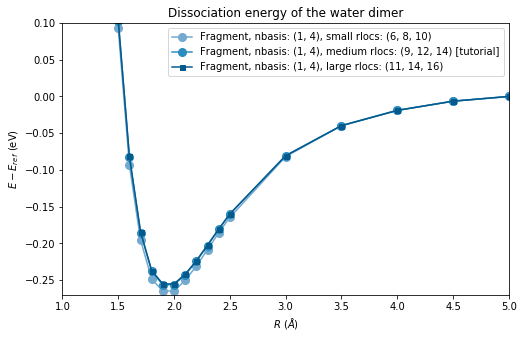

In [17]:
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d']
markers = ['o']*2 + ['s']
size = [8]*2 + [5]

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-0.27, 0.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

**Conclusion:**

The tutorial values for the different rlocs give a converged dissociation curve compared to the larger rlocs. We also see that using smaller values may lead to different results. Here, using smaller rlocs tend to overbind the dimer by 10 meV. **Why is that? Didn't try to understand that yet.** The overbinding for smaller rlocs is still visible for higher values of *nbasis* (you may want to try it by yourself).

## Influence of the rmult parameters

In this part of the notebook, we test the influence of the values of the multiplying factors for the coarse and fine grids (*crmult* and *frmult* respectively).

They multiply quantities that are chemical species dependent. The first factor is the most important since it describes the spatial expansion of the basis set (in yellow on the figure below). Indeed the basis set is defined as a set of real space points with non-zero values. These points are on a global regular mesh and located inside spheres centered on atoms. Increasing the first multiplying factor means that further spatial expansion is possible for the wavefunctions. Typical values are 5 to 7.

To check the influence of these parameters on the quantities of interest is among the first thing to look for when performing a cubic scalic BigDFT calculation, as shown in [this tutorial](http://bigdft.org/Wiki/index.php?title=Basis-set_convergence). Let us perform the same study here for the fragment approach.

<img style="float: left;", src="http://bigdft.org/images/7/72/CH4-grid.png">

### Templates

Let us first run a template calculation for a larger set of *rmult* factors:

In [18]:
# Go to the templates folder
os.chdir(templates_path)

# Run the template of the H2O molecule
template_yaml = h2o_yaml(rm=[7.0, 8.0])
run_bigdft(template_yaml, h2o_xyz, prefix="h2o_medium_rm")

Logfile log-h2o_medium_rm.yaml already exists!


The next template is the same as the previous one, but with a larger value of *crmult*:

In [19]:
small_rlocs = [6.0, 8.0, 10.0]
template_yaml = h2o_yaml(rm=[9.0, 8.0])
run_bigdft(template_yaml, h2o_xyz, prefix="h2o_large_rm")

Logfile log-h2o_large_rm.yaml already exists!


### Dissociation curves

Again, once the templates have been calculated, one can run the fragments calculation to get the dissociation curves

Let us first start with the medium *rmults*:

In [20]:
# Go to the dimer folder
os.chdir(dimer_path)

# Define the input file
yaml = dimer_yaml(rm=[7.0, 8.0], frag_name="h2o_medium_rm")

# Run the first setup
run_setup("fragment_1-4_medium_rm", dists, yaml, 
          dimer_xyz, templates_dir=templates_path)

fragment_1-4_medium_rm; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=2.4
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=2.5
Logfile log-dimer.yaml already exists!
fragment_1-4_medium_rm; dist=3.0
Logfile log-dimer.yaml already 

Finally, perform the calculations of the second setup, with large *rmults*:

In [21]:
# Define the input file
yaml = dimer_yaml(rm=[9.0, 8.0], frag_name="h2o_large_rm")

# Run the second setup
run_setup("fragment_1-4_large_rm", dists, yaml, \
          dimer_xyz, templates_dir=templates_path)

fragment_1-4_large_rm; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=2.4
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=2.5
Logfile log-dimer.yaml already exists!
fragment_1-4_large_rm; dist=3.0
Logfile log-dimer.yaml already exists!
fragme

It is then possible to get the data for each setup:

In [22]:
setups = ["fragment_1-4", "fragment_1-4_medium_rm", "fragment_1-4_large_rm"]
legends = ['Fragment, nbasis: (1, 4), small rm: (5, 7) [tutorial]', \
           'Fragment, nbasis: (1, 4), medium rm: (7, 8)', \
           'Fragment, nbasis: (1, 4), large rm: (9, 8)']
curves = [find_data(setup, legends[i]) for i, setup in enumerate(setups)]

Fragment, nbasis: (1, 4), small rm: (5, 7) [tutorial]
Fragment, nbasis: (1, 4), medium rm: (7, 8)
Fragment, nbasis: (1, 4), large rm: (9, 8)


Create the plot: 

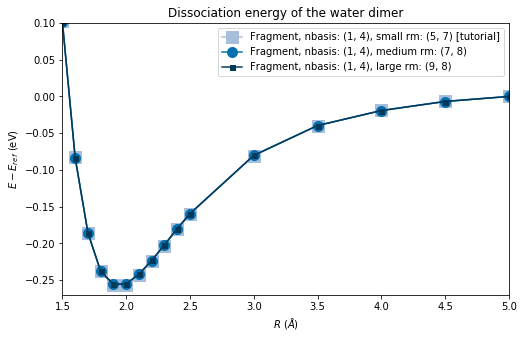

In [23]:
# Lists of markers and colors (for matplotlib)
colors = ['#a6bddb', '#0570b0', '#023858']
markers = ['s', 'o', 's']
size = [12, 10, 5]

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-0.27, 0.1])
plt.xlim([1.5, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

**Conclusion:**

The dissociation curve of the tutorial is already converged with respect to the crmult and frmult parameters, since inceasing them lead to no change. The smallest values used are therefore sufficient for this study.

## Different confinements

A confining potential centered on each atom is used to enforce the localization of the support functions at the beginning of linear BigDFT calculations. It is finally turned off, to give highly accurate support functions (see [S. Mohr *et al.*, The Journal of Chemical Physics 140, 204110 (2014)](http://aip.scitation.org/doi/abs/10.1063/1.4871876) for more details, especially section **IV.A**). 

The present section aims at studying the influence of the strength of this confinement on the dissociation curves.

### Templates calculation

Define a set of confinement strengths to be tested and run the templates calculations:

In [24]:
# Go to the templates folder
os.chdir(templates_path)

# Prepare the templates
confinements = [0.0025, 0.005, 0.008, 0.01, 0.02, 0.05, 0.1]

# Run the templates of the H2O molecule
for conf in confinements:
    template_yaml = h2o_yaml(confinement=[conf, conf, 0.0])
    run_bigdft(template_yaml, h2o_xyz, prefix='h2o_confinement_'+str(conf))

Logfile log-h2o_confinement_0.0025.yaml already exists!
Logfile log-h2o_confinement_0.005.yaml already exists!
Logfile log-h2o_confinement_0.008.yaml already exists!
Logfile log-h2o_confinement_0.01.yaml already exists!
Logfile log-h2o_confinement_0.02.yaml already exists!
Logfile log-h2o_confinement_0.05.yaml already exists!
Logfile log-h2o_confinement_0.1.yaml already exists!


### Dissociation curves

Then run the fragment calculations for the diferent distances in order to get the dissociation curves:

In [25]:
# Go to the dimer folder
os.chdir(dimer_path)

for conf in confinements:
    print("Confinement: {}".format(conf))
    # Define the input file
    yaml = dimer_yaml(confinement=[conf, conf, 0.0], frag_name="h2o_confinement_"+str(conf))
    # Run the first setup
    run_setup("fragment_1-4_confinement_"+str(conf), dists, yaml, 
              dimer_xyz, templates_dir=templates_path)

Confinement: 0.0025
fragment_1-4_confinement_0.0025; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4_confinement_0.0025; dist=2.4
Logfile log-dimer.yaml already exists!
fragment

It is then possible to get the data for each setup:

In [26]:
setups = ["fragment_1-4"] + ["fragment_1-4_confinement_"+str(conf) for conf in confinements]
legends = ['Fragment, nbasis: (1, 4) [tutorial]'] + \
          ['Fragment, nbasis: (1, 4), confinement '+str(conf) for conf in confinements]
curves = [find_data(setup, legends[i]) for i, setup in enumerate(setups)]

Fragment, nbasis: (1, 4) [tutorial]
Fragment, nbasis: (1, 4), confinement 0.0025
Fragment, nbasis: (1, 4), confinement 0.005
Fragment, nbasis: (1, 4), confinement 0.008
Fragment, nbasis: (1, 4), confinement 0.01
Fragment, nbasis: (1, 4), confinement 0.02
Fragment, nbasis: (1, 4), confinement 0.05
Fragment, nbasis: (1, 4), confinement 0.1


Create the plot: 

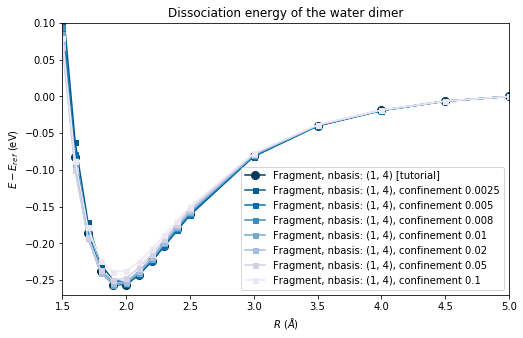

In [27]:
# Lists of markers and colors (for matplotlib)
colors = ['#023858', '#045a8d', '#0570b0', '#3690c0', '#74a9cf', '#a6bddb', '#d0d1e6', '#ece7f2']
markers = ['o'] + ['s']*len(confinements)
size = [8] + [5]*len(confinements)

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-0.27, 0.10])
plt.xlim([1.5, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

The long distance fragment calculations are not impacted by the confinement values. This comforts the validity of the templates clculations. Remember that this confinement strength is gradually decreased to reach zero at the end of the calculations. Since almost no difference is observed for long distances, it means that all the templates calculations ended with support functions that are almost the same. This is evidenced by the energies of the templates:

In [28]:
logs_confinement = find_files('../'+templates_folder+'/log-h2o_confinement_*yaml')
for log_path in logs_confinement:
    log = lf.Logfile(log_path)
    print("Logfile: {}; Energy = {}".format(log_path, log.energy))

Logfile: ../templates/log-h2o_confinement_0.0025.yaml; Energy = -17.1816298648
Logfile: ../templates/log-h2o_confinement_0.005.yaml; Energy = -17.1816270202
Logfile: ../templates/log-h2o_confinement_0.008.yaml; Energy = -17.1816289062
Logfile: ../templates/log-h2o_confinement_0.01.yaml; Energy = -17.1816299572
Logfile: ../templates/log-h2o_confinement_0.02.yaml; Energy = -17.1816299494
Logfile: ../templates/log-h2o_confinement_0.05.yaml; Energy = -17.1816298863
Logfile: ../templates/log-h2o_confinement_0.1.yaml; Energy = -17.1816299203


However, this agreement disappears for short distances:

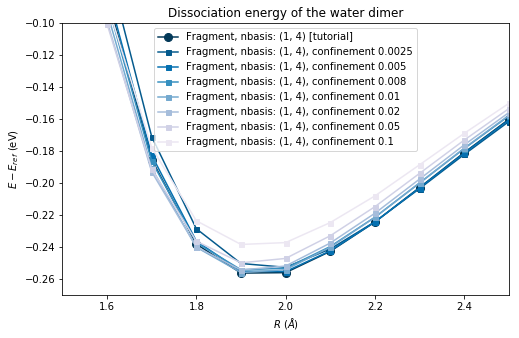

In [29]:
# Lists of markers and colors (for matplotlib)
colors = ['#023858', '#045a8d', '#0570b0', '#3690c0', '#74a9cf', '#a6bddb', '#d0d1e6', '#ece7f2']
markers = ['o'] + ['s']*len(confinements)
size = [8] + [5]*len(confinements)

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-0.27, -0.10])
plt.xlim([1.5, 2.5])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

The previous two plots may have too many superimposing data to be easily understood, but there seems to be a range of confinement strengths which leads to a convergence of the dissociation curve, in the sense that the curve is not altered too much before and after the equilibrium distance. 

To get a clearer view on s happening, let us take the tutorial dissociation curve as a reference:

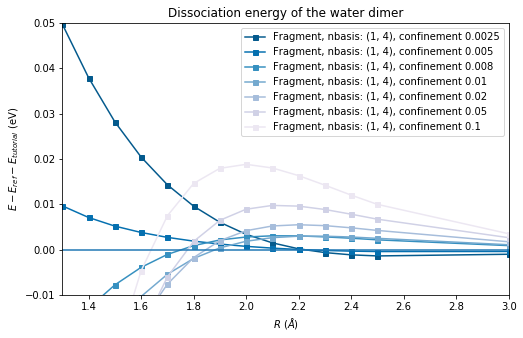

In [30]:
# Lists of markers and colors (for matplotlib)
colors = ['#045a8d', '#0570b0', '#3690c0', '#74a9cf', '#a6bddb', '#d0d1e6', '#ece7f2']
markers = ['s']*len(confinements)
size = [5]*len(confinements)

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves[1:]):
    plt.plot(data['distances'], data['energies']-curves[0]['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-0.01, 0.05])
plt.xlim([1.3, 3.0])
plt.axhline(0)
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}-E_{tutorial}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

There is actually no dissociation curves that gets below the reference at long, medium and short distance at the same time. If there was a setup giving a more converged dissociation curve than the reference, then it would never go higher than 0. This is never the case here:

* if the confinement strength is too small, then the energy for short distances is too high,

* if the confinement strength is too high, then the binding energy is too small: therefore, this dissociation curve may not be considered as a reference, even if it predicts lower energies for shorter distances, since it has

Why is that, if the templates are all the same? Well, a confinement potential is also used during the fragment calculations for each distance. How does it impact the results? One way to see that is to use the templates found using the strongest and the weakest confinement strengths while using the confinement strength of the tutorial for the fragment calculations.

### Perform the proposed tests:

In [31]:
test_setups = {'strong': 0.01, 'weak': 0.0025}
for key, val in test_setups.items():
    # Define the input file
    yaml = dimer_yaml(frag_name="h2o_confinement_"+str(val))
    # Run the first setup
    run_setup("fragment_1-4_"+str(key)+"_confinement", dists, yaml, \
              dimer_xyz, templates_dir=templates_path)

fragment_1-4_strong_confinement; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinement; dist=2.4
Logfile log-dimer.yaml already exists!
fragment_1-4_strong_confinem

### Compare the new dissociation curves with the tutorial reference

In [32]:
new_setups = ["fragment_1-4_"+str(key)+"_confinement" for key in test_setups]
new_legends = ['Fragment, nbasis: (1, 4) strong template confinement', \
               'Fragment, nbasis: (1, 4) weak template confinement']
new_curves = [find_data(setup, new_legends[i]) for i, setup in enumerate(new_setups)]

Fragment, nbasis: (1, 4) strong template confinement
Fragment, nbasis: (1, 4) weak template confinement


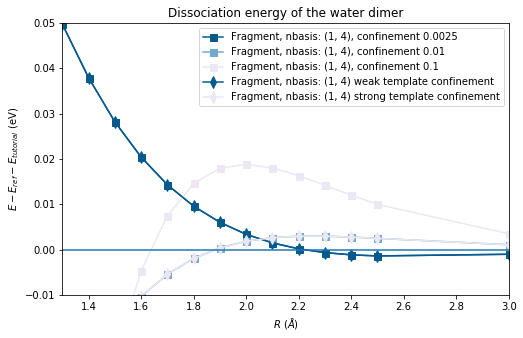

In [33]:
# Lists of markers and colors (for matplotlib)
colors = ['#045a8d', '#74a9cf', '#ece7f2', '#045a8d', '#ece7f2']
markers = ['s']*3 + ['d']*2
size = [7]*3 + [8]*2

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate([curves[1], curves[4], curves[-1]]+[new_curves[1], new_curves[0]]+[]):
    plt.plot(data['distances'], data['energies']-curves[0]['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.axhline(0)
plt.ylim([-0.01, 0.05])
plt.xlim([1.3, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}-E_{tutorial}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

* The dissociation curve obtained using the strongly confined template is better behaved if the fragment calculation uses a smaller confinement, but it does not match the tutorial values, rather it gives the results obtained using a confinement strength of 0.01 (indicating that only one of the two confinement variables is implied in this change: **why is that?**).

* The dissociation curve obtained using the weakly confined template is not impacted by the stronger confinement used during the fragment calculation: **why is that?**.

Even if all the templates have the same energies, this shows that it is more important to tune the confinement of the templates calculations rather than that of the fragment calculations.

**Conclusion:**

There is a range of confinement strengths (between 0.005 and 0.01) that leads to a convergence of the dissociation curves. If the impact is rather limited for long distances, it can be of the same order as the influence of the *rloc* parameters on the dissociation energy.

## Test allowing for basis optimization

The water template of the tutorial is kept as a starting point for this test, but an optimization of the support functions is allowed for each distance.

### Dissociation curve

In [34]:
# Go to the dimer folder
os.chdir(dimer_path)

# Define the input file
yaml = dimer_yaml(with_nit=[False, False])
#print(yaml)

# Run the first setup
run_setup("fragment_1-4_with_basis_opt", dists, yaml, 
          dimer_xyz, templates_dir=templates_path)

fragment_1-4_with_basis_opt; dist=1.3
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=1.4
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=1.5
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=1.6
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=1.7
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=1.8
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=1.9
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=2.0
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=2.1
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=2.2
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=2.3
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=2.4
Logfile log-dimer.yaml already exists!
fragment_1-4_with_basis_opt; dist=2.5
Logfile log-dimer.yaml already exists!

It is then possible to get the data for each setup:

In [35]:
setups = ["fragment_1-4", "linear_1-4", "fragment_1-4_with_basis_opt"]
legends = ['Fragment, nbasis: (1, 4), without basis optimization [tutorial]', \
           'Linear, nbasis: (1, 4) [tutorial]', \
           'Fragment, nbasis: (1, 4), with basis optimization']
curves = [find_data(setup, legends[i]) for i, setup in enumerate(setups)]

Fragment, nbasis: (1, 4), without basis optimization [tutorial]
Linear, nbasis: (1, 4) [tutorial]
Fragment, nbasis: (1, 4), with basis optimization


Create the plot: 

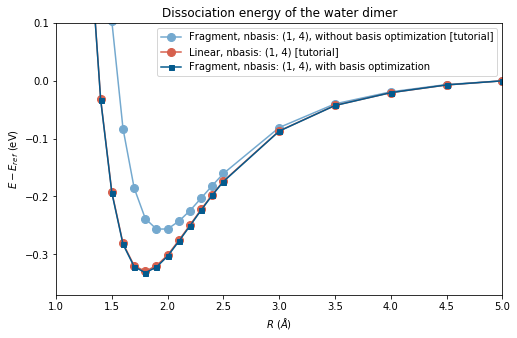

In [36]:
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#d6604d', '#045a8d']
markers = ['o', 'o', 's']
size = [8, 8, 5]

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-0.37, 0.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

**Conclusion:**

If there is an optimization of the basis at each distance, this amounts to perform a linear calculation on the full system. This is why the dissociation curve of the fragment calculation allowing for basis set optimization reproduces the one obtained using the linear calculation on the full system (the latter being cheaper in terms of computing resources). 

Therefore, there is actually no point in optimizing the basis set while performing fragment calculations, as it is very inefficient compared to a linear calculation on the full system.

## Create archives

To avoid running all calculations when running this notebook again, we create two archives as tar files:

* one containing all logs _log-dimer*_ and all input files *dimer.yaml* and positions *dimer.xyz* for each setup,

* another one containing all data for the templates (output and input files _template*xyz_, _template*xyz_ plus the folders _data-template*_)

In [39]:
# Go back to the starting folder, with both templates and dimer folders
os.chdir(start_path)

# List the setups to send to the setup archive
setups = ['fragment_1-4', 'fragment_1-4_large_rlocs', 'fragment_1-4_small_rlocs', \
          'fragment_1-4_large_rm', 'fragment_1-4_medium_rm', 'fragment_1-4_with_basis_opt', \
          'fragment_1-4_strong_confinement', 'fragment_1-4_weak_confinement', \
          'fragment_1-4_confinement_0.0025', 'fragment_1-4_confinement_0.005', \
          'fragment_1-4_confinement_0.008', 'fragment_1-4_confinement_0.01', \
          'fragment_1-4_confinement_0.02', 'fragment_1-4_confinement_0.05', \
          'fragment_1-4_confinement_0.1', 'linear_1-4']

# Create an archive with logs and input files for each setup
if not os.path.exists(tarname):
    tar = tarfile.open(tarname, "w:bz2")
    for setup in setups:
        logfiles = find_files(dimer_folder+"/"+setup+"/dimer_*/log-dimer*.yaml")
        input_files = find_files(dimer_folder+"/"+setup+"/dimer_*/dimer.yaml")
        posinp_files = find_files(dimer_folder+"/"+setup+"/dimer_*/dimer.xyz")
        for name in logfiles + input_files + posinp_files:
            tar.add(name)
    tar.close()
    print("Creation of a tar file with all log files: {}".format(tarname))
else:
    print("No creation of tarfile {} because it already exists!".format(tarname))

# List the templates to send to the template archive
templates = ['h2o', 'h2o_large_rlocs', 'h2o_small_rlocs', 'h2o_large_rm', \
             'h2o_medium_rm', 'h2o_confinement_0.0025', 'h2o_confinement_0.005', \
             'h2o_confinement_0.008', 'h2o_confinement_0.01', 'h2o_confinement_0.02', \
             'h2o_confinement_0.05', 'h2o_confinement_0.1']

# Create a second archive with templates data
if not os.path.exists(tartemplate):
    tar = tarfile.open(tartemplate, "w:bz2")
    for template in templates:
        data_folders = [templates_folder+'/data-'+template+"/"+f 
                        for f in find_files(templates_folder+'/data-'+template)]
        logfiles = find_files(templates_folder+"/log-"+template+".yaml")
        input_files = find_files(templates_folder+"/"+template+".yaml")
        posinp_files = find_files(templates_folder+"/"+template+".xyz")
        for name in data_folders + logfiles + input_files + posinp_files:
            tar.add(name)
    tar.close()
    print("Creation of a tar file with all log files: {}".format(tartemplate))
else:
    print("No creation of tarfile {} because it already exists!".format(tartemplate))

No creation of tarfile H2O_dimer_tests.tgz because it already exists!
Creation of a tar file with all log files: templates_tests_H2O.tgz
